In [1]:
import pandas as pd
import os
import glob
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import earthpy as et


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from keras.layers import Activation

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# flag = 0 -> daily result
# flag = 1 -> weekday result
# flag = 2 -> hourly result
# flag = 3 -> all tweets result

flag = 0

In [3]:
files = []
count = 0

# for name in glob.glob('City/*'):
for name in glob.glob('City_with_RT/*'):
    files.append(name)
    
### calculate the total rows

total_row = 0

for x in files:
    df = pd.read_csv(x)
    count_row = df.shape[0]
    total_row += count_row

print("Total rows in the dataset: ", total_row)

frames = []

for x in files:
    df = pd.read_csv(x)
    frames.append(df)

### Merge all the datasets
merged_df = pd.concat(frames)

Total rows in the dataset:  471477


In [4]:
### Preprocess the data

date_time = []
date_format = '%Y-%m-%d %H:%M:%S'

for i in merged_df['created_at']:
    date_time.append(i[:-6])

merged_df['Date_time'] = date_time

# Reorder column
mid = merged_df['Date_time']
merged_df.drop(labels=['Date_time'], axis=1,inplace = True)
merged_df.insert(0, 'Date_time', mid)

merged_df['Date_time'] = pd.to_datetime(merged_df['Date_time'], format = date_format)

### Only want the rows between the date 2020-10-08 to 2020-10-26

df = merged_df[~(merged_df['Date_time'] < '2020-10-12 00:00:00')]
df = df[~(df['Date_time'] > '2020-10-25 23:59:59')]



In [5]:
### Removing outliers

df = df[df['retweet_count'] != 0]

df = df[df['retweet_count'].between(df['retweet_count'].quantile(.15), df['retweet_count'].quantile(.85))]
# df = df[df['positive'].between(df['positive'].quantile(.15), df['positive'].quantile(.85))]
# df = df[df['negative'].between(df['negative'].quantile(.15), df['negative'].quantile(.85))]
# df = df[df['compound'].between(df['compound'].quantile(.15), df['compound'].quantile(.85))]

df.shape

(124345, 15)

In [6]:
subset_df = df.drop(columns = ['created_at', 'text','neutral'])

corr_matrix = subset_df.corr()

c = subset_df.corr()

s = c.unstack().abs()
so = s.sort_values(kind="quicksort", ascending = False)

a = so[(so != 1)].dropna()

for i in range(0,10):
    if a[i] == a[i+1]:
        if a[i] > 0.3:
            print(a.index[i], a[i])

('positive', 'compound') 0.7479903769653261
('listed_count', 'followers_count') 0.7429511176264136
('negative', 'compound') 0.6773678644572478
('statuses_count', 'favorites_count') 0.516663203041585


In [7]:
subset_df = subset_df.drop(columns = ['listed_count', 'favorite_count'])

subset_df = subset_df.reset_index()
subset_df = subset_df.drop(columns=['index'])

In [8]:
### Refer to http://hselab.org/daily-averages-1.html
### Function to virtualize the data

def city_avg(city, time):
    
    values = ['positive', 'negative', 'compound']
    

    df = subset_df[subset_df['city'] == city]          
    
    df = df.reset_index()
    df = df.drop(columns=['index'])
    
    if time == 'daily':
        df[time] = df['Date_time'].map(lambda x: x.date())
        df[time] = df[time].astype('category')
    
    elif time == 'weekday':
        df[time] = df['Date_time'].map(lambda x: x.weekday()) + 1
        df[time] = df[time].astype('category')
        
    elif time == 'hourly':
        df['day'] = df['Date_time'].map(lambda x: x.date())
        df['day'] = df['day'].astype('category')
        
        df[time] = df['Date_time'].map(lambda x: x.hour)
        df[time] = df[time].astype('category')
        
        df['temp'] = df[['day', 'hourly']].astype('str').apply('_'.join, axis=1)
        df['day_hourly'] = df['temp'].str[0:10] + '_' + df['temp'].str.split('_').str[1]
                
        time = 'day_hourly'
    
    df = df.groupby(time).mean()
    df = df.round(4)
    
    
    
    for i in values:
        # Use white grid plot background from seaborn
        sns.set(font_scale=1.5, style="whitegrid")
        # Create figure and plot space
        fig, ax = plt.subplots(figsize=(20, 20))
        # Add x-axis and y-axis
        ax.plot(df.index,
            df[i],
            color='purple')
        # Set title and labels for axes
        ax.set(xlabel=time,
            ylabel=i,
            title= time+": "+i+" "+ "value")
        
        if time == 'day_hourly':
            start, end = ax.get_xlim()
            ax.xaxis.set_ticks(np.arange(start, end, 48))
        
            plt.xticks(rotation=45)

        plt.show()
    
    return df

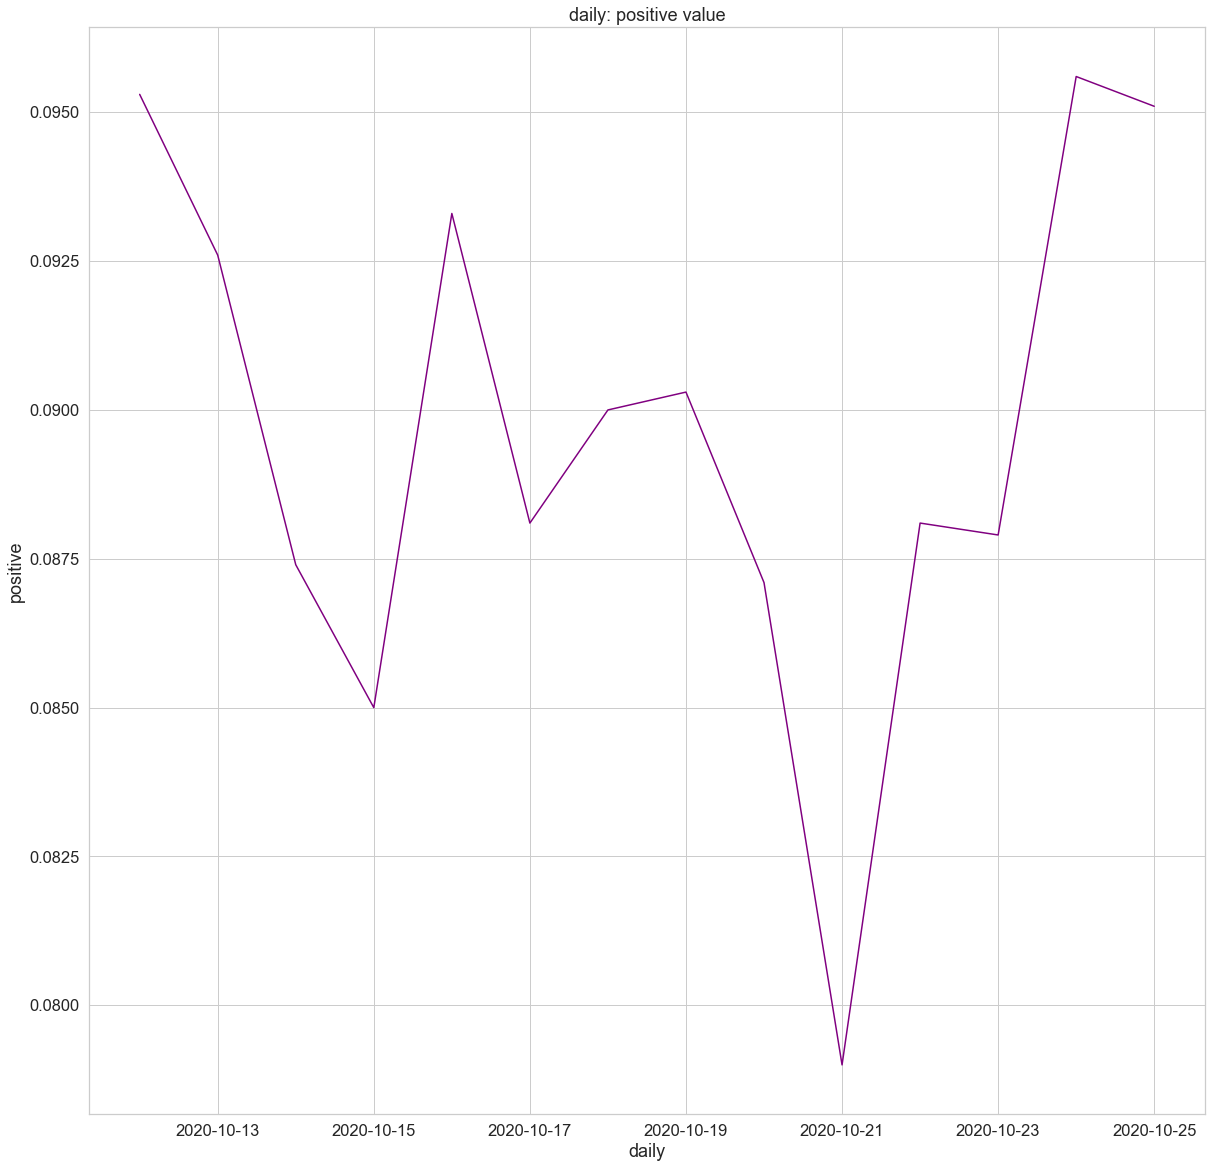

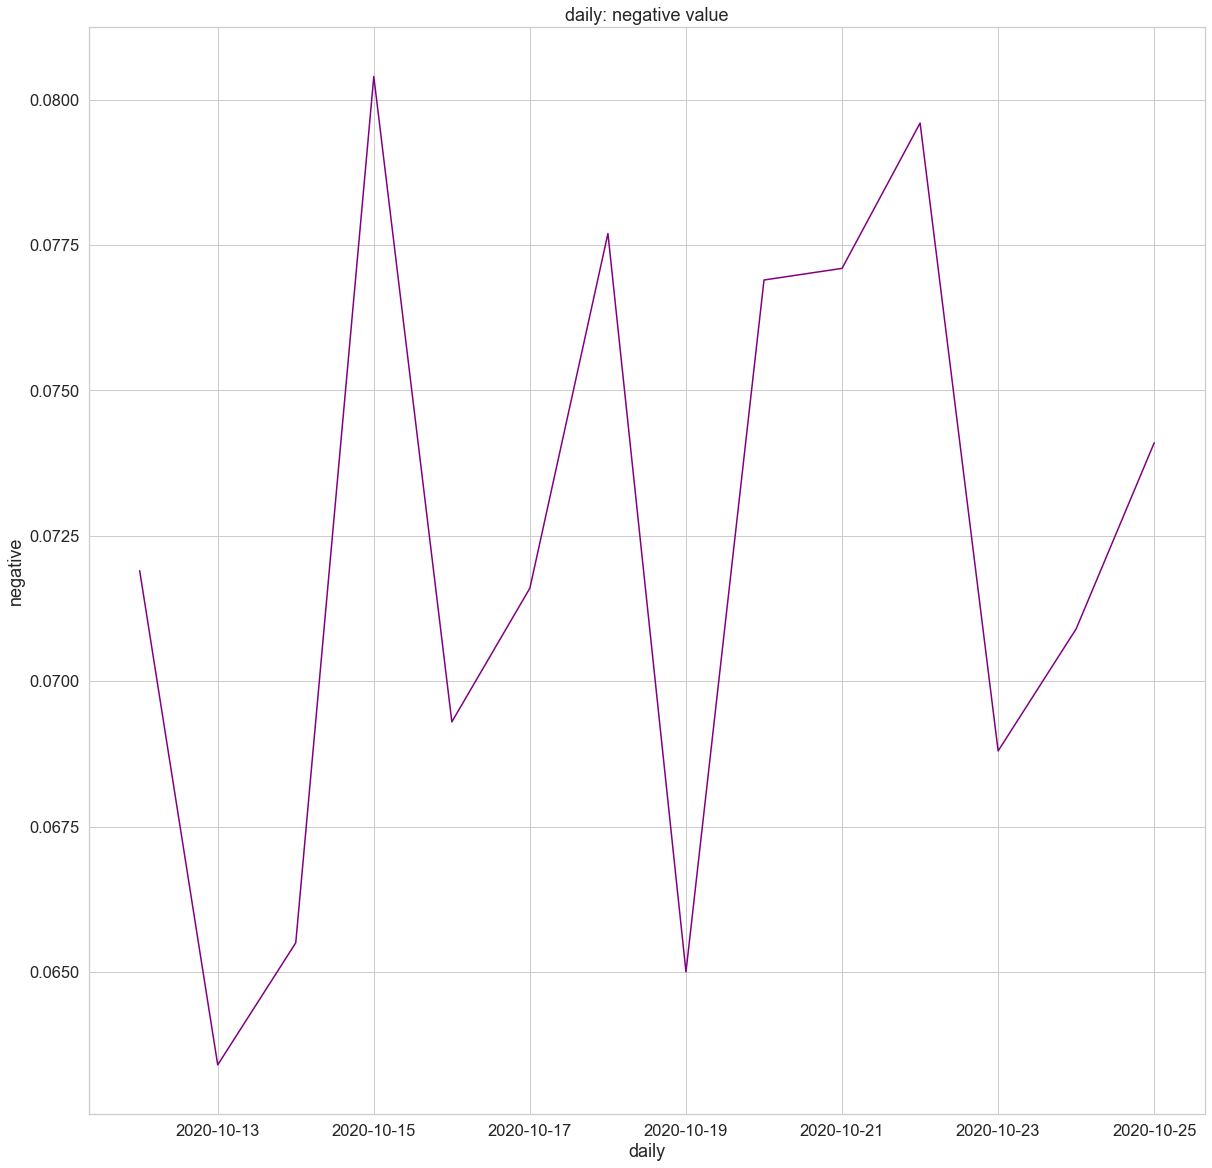

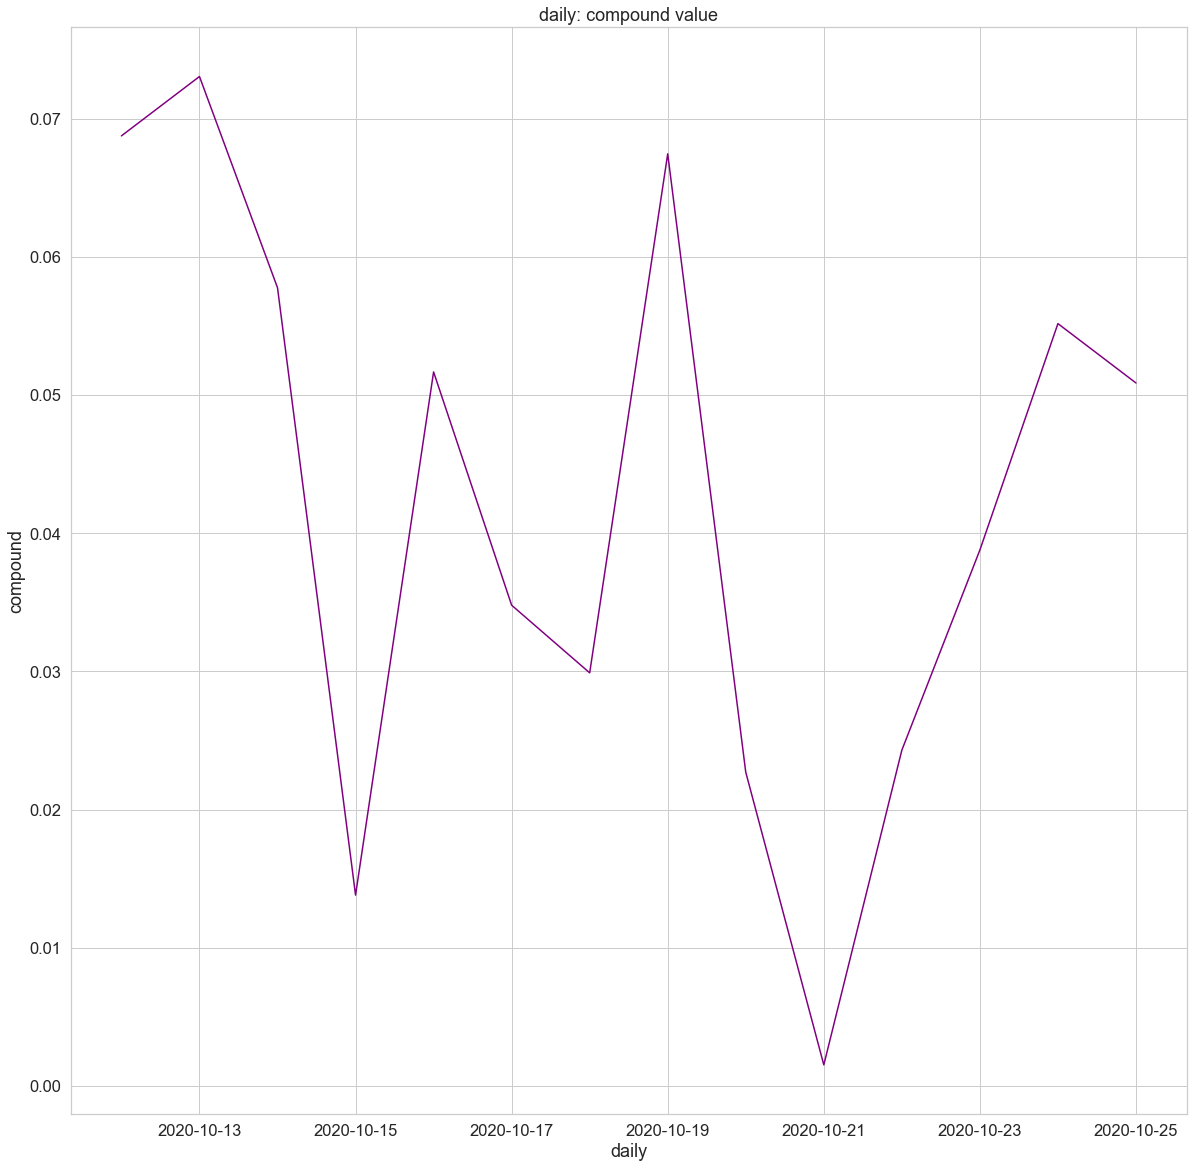

In [9]:
if flag == 0:
    df = city_avg('new_york_city', 'daily')

if flag == 1:
    df = city_avg('new_york_city', 'weekday')

if flag == 2:
    df = city_avg('new_york_city', 'hourly')

if flag == 3:
    df = subset_df
    le = LabelEncoder()
    df.city = df.city.astype('category')
    city_cat_dict = dict(enumerate(df.city.cat.categories))
    df['city'] = le.fit_transform(df['city'])
    df = df.drop(columns = ['Date_time'])
    city_cat_dict


In [10]:
df.columns[0]

'retweet_count'

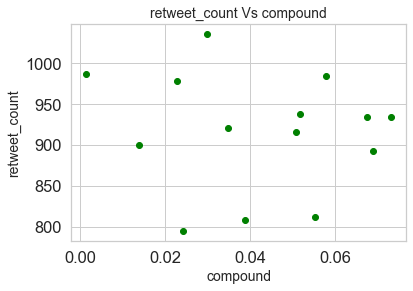

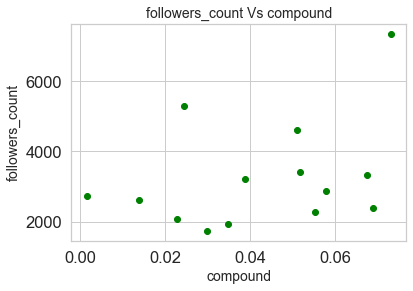

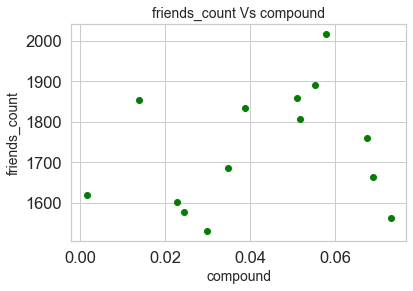

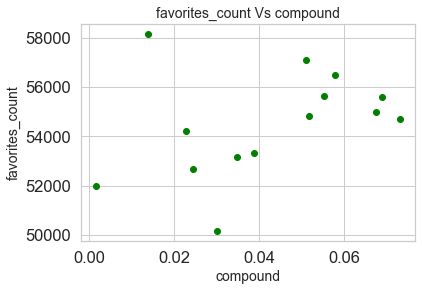

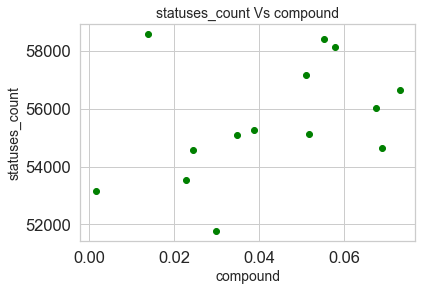

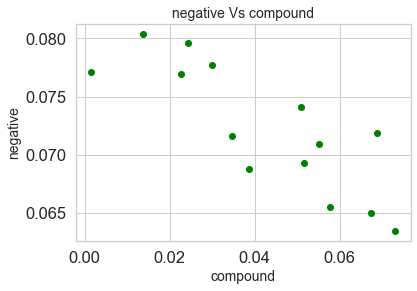

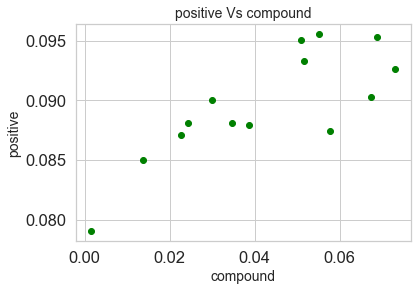

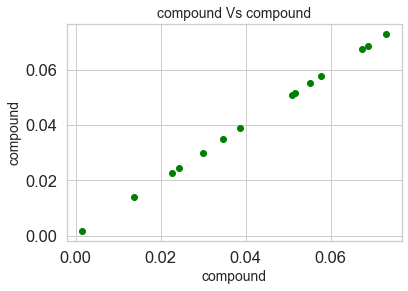

In [11]:
## Check Linearity

dependent = 'compound'
independent = df.columns

import matplotlib.pyplot as plt

for i in independent:
    plt.scatter(df[dependent], df[i], color='green')
    plt.title(i + ' Vs ' + dependent, fontsize=14)
    plt.xlabel(dependent, fontsize=14)
    plt.ylabel(i, fontsize=14)
    plt.grid(True)
    plt.show()

In [12]:
if flag == 3:

    shuffle_index = np.random.permutation(df.shape[0])

    df_shuffle = df.reindex(shuffle_index)

# grouped_df = grouped_df.drop(grouped_df.index[186])

In [13]:
X = df.drop(columns = ['compound', 'negative', 'positive'])
# X = df.iloc[:,3:6]
y = df['compound']


In [14]:
if flag == 3:
    val_num = round(X.shape[0] * 0.1)

    X, X_validate, y, y_validate = X[val_num:], X[:val_num], y[val_num:], y[:val_num]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:

# Create model

def neural_net():
    model = Sequential()

    model.add(Dense(128, activation="tanh", input_dim=6))
    model.add(Dropout(.2))
    model.add(Activation("linear"))
    model.add(Dense(64, activation="relu"))
    model.add(Activation("linear"))
    model.add(Dense(32, activation="relu"))
    model.add(Activation("linear"))
    model.add(Dense(16, activation="relu"))
    model.add(Activation("linear"))
    model.add(Dense(1))


    # Compile model: The model is initialized with the Adam optimizer and then it is compiled.
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200), metrics=["accuracy"])
    
    return model


#     # Fit the model
#     history = model.fit(X, y, epochs=10, batch_size=1000, verbose=2, callbacks=[es])

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

if flag == 3:
    # Patient early stopping
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1)

    neural_network = KerasRegressor(build_fn=neural_net, 
                                     epochs=10, 
                                     batch_size=1000, 
                                     verbose=2)
    
    cross_val_score(neural_network, X, y, cv=3)
    
    m = neural_net()

    y_pred = m.predict(X_test)
    print("\n\n\n")
    print("MSE for testing: ", mean_squared_error(y_test, y_pred))

In [17]:
import statsmodels.api as sm

mod = sm.OLS(y,X)
fii = mod.fit()
fii.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               compound   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              9.701
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                     0.00200
Time:                        16:23:39   Log-Likelihood:                          35.863
No. Observations:                  14   AIC:                                     -61.73
Df Residuals:                       9   BIC:                                     -58.53
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
retweet_count   -1.042e-05   8.26e-05     -0.126      0.902      -0.000       0.000
followers_count  6.308e-06   5.15e-06      1.224      0.252   -5.35e-06     1.8e-05
friends_count    5.561e-05   7.42e-05      0.749      0.473      -0.000       0.000
favorites_count  1.817e-06   6.26e-06      0.290      0.778   -1.23e-05     1.6e-05
statuses_count  -2.954e-06   6.61e-06     -0.447      0.666   -1.79e-05     1.2e-05
==============================================================================
Omnibus:                        0.516   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.570
Skew:                          -0.211   Prob(JB):                        0.752
Kurtosis:                       2.106   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
if flag == 0:

    df_2 = pd.read_csv('nyc_data.csv')

    df_2 = df_2[:-3]
    df_2 = df_2.iloc[2:]
    df_2 = df_2.iloc[:, 0:6]
    df_2 = df_2[4:]

    df_2 = df_2.rename(columns={'Unnamed: 0': 'daily', 'NYC New Cases': 'NYC_New_Cases', 'NYC Hospitalization': 'NYC_Hospitalization', 'NYC Deaths': 'NYC_Deaths', 'National New Cases': 'National_New_Cases', 'National New Deaths': 'National_New_Deaths', 'AVG Temperature': 'AVG_Temperature', 'Wind Speed': 'Wind_Speed'})

    df_2 = df_2.reset_index()
    X = df_2.drop(columns=['index'])

    X = X.drop(columns = ['daily'])

In [19]:
if flag == 0:
    rows_with_zeros = []
    for index, row in X.iterrows():
        if row[0] == 0:
            rows_with_zeros.append(index)

    y2 = y.to_frame()
    y2 = y2.reset_index()
    y2 = y2.drop(columns = ['daily'])

In [20]:
if flag == 0:

    X2 = pd.DataFrame()
    y3 = pd.DataFrame()

    for i in range(0,14):
        if i in rows_with_zeros:
            continue

        X2 = X2.append(X.iloc[i])
        y3 = y3.append(y2.iloc[i])
    
    X, X_test, y, y_test = X2[3:], X2[:3], y3[3:], y3[:3]

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

if flag == 0:
    lin_reg = LinearRegression()

    lin_reg.fit(X, y)
    print(lin_reg.intercept_, lin_reg.coef_)
    
    y_pred = lin_reg.predict(X_test)
    print("MSE for testing: ", mean_squared_error(y_test, y_pred))

[3.23700164] [[-0.04400846  0.00084669 -0.0015392   0.00020682 -0.00042454]]
MSE for testing:  0.0005033241592270267


In [24]:
import statsmodels.api as sm

if flag == 0:
    mod = sm.OLS(y3,X2)
    fii = mod.fit()
    print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:               compound   R-squared (uncentered):                   0.865
Model:                            OLS   Adj. R-squared (uncentered):              0.729
Method:                 Least Squares   F-statistic:                              6.389
Date:                Wed, 18 Nov 2020   Prob (F-statistic):                      0.0314
Time:                        16:37:42   Log-Likelihood:                          26.088
No. Observations:                  10   AIC:                                     -42.18
Df Residuals:                       5   BIC:                                     -40.66
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
